In [71]:
import xarray as xr
import cubo
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import waldbrand_tools as wt


band 2 = blue
band 3 = green
band 4 = Red
band 8 = NIR
band 12 = SWIR

In [72]:
da_before = cubo.create(
   lat=39.9756, # Central latitude of the cube
   lon=-8.1556, # Central longitude of the cube
   collection="sentinel-2-l2a", # Name of the STAC collection
   bands=["B02","B03","B04","B08","B12"], # Bands to retrieve
   start_date="2017-06-13", # Start date of the cube
   end_date="2017-06-15", # End date of the cube
   edge_size=46000, # Edge size of the cube 46000
   units = "m",
   resolution=10, # Pixel size of the cube (m)
)

In [73]:
da_after = cubo.create(
   lat=39.9756, # Central latitude of the cube
   lon=-8.1556, # Central longitude of the cube
   collection="sentinel-2-l2a", # Name of the STAC collection
   bands=["B02","B03","B04","B08","B12"], # Bands to retrieve
   start_date="2017-07-03", # Start date of the cube
   end_date="2017-07-05", # End date of the cube
   edge_size=46000, # Edge size of the cube 46000
   units = "m",
   resolution=10, # Pixel size of the cube (m)
)

In [74]:
# RGB Before
# Extract Bands from Xarray szene
B02_before = da_before.sel(band=["B02"]).squeeze()
B03_before = da_before.sel(band=["B03"]).squeeze()
B04_before = da_before.sel(band=["B04"]).squeeze()

# Stack rgb
rgb_stack_before = xr.concat([B04_before, B03_before, B02_before], dim="band")

# Convert stack to numpy
rgb_array_before = rgb_stack_before.to_numpy()

# Transpose to (height, width, 3) for imshow
rgb_array_before = np.transpose(rgb_array_before, (1, 2, 0))

# Scale so we can see more in the image
rgb_before = wt.scale(rgb_array_before)

In [75]:
# RGB after
# Extract Bands from Xarray scene
B02_after = da_after.sel(band=["B02"]).squeeze()
B03_after = da_after.sel(band=["B03"]).squeeze()
B04_after = da_after.sel(band=["B04"]).squeeze()

# Stack rgb
rgb_stack_after = xr.concat([B04_after, B03_after, B02_after], dim="band")

# Convert stack to numpy
rgb_array_after = rgb_stack_after.to_numpy()

# Transpose to (height, width, 3) for imshow
rgb_array_after = np.transpose(rgb_array_after, (1, 2, 0))

# Scale so we can see more in the image
rgb_after = wt.scale(rgb_array_after)


In [76]:
# calculate ndwi to create a mask
ndwi_before = wt.ndwi(da_before)

# create ater mask
water_mask_before, legend = wt.water_mask(ndwi_before, 0.1) # th = threshold for reclassification

# # Plotting the water mask
# plt.figure(figsize=(10, 8))
# plt.title("Water Mask")
# cmap = plt.cm.get_cmap("viridis", len(legend))  # 2 discrete values
# mask_plot = plt.imshow(water_mask_before.squeeze(), cmap="cool", interpolation="nearest")
# cbar = plt.colorbar(mask_plot, ticks=range(len(legend)))
# cbar.ax.set_yticklabels([legend[val] for val in sorted(legend.keys())])
# cbar.set_label("Water Classification")
# plt.show()

In [77]:
# calculate nbr for pre- and post fire
prefire_nbr = wt.nbr(da_before)
postfire_nbr = wt.nbr(da_after)

# Apply the water mask to prefire and postfire NBR
prefire_nbr = wt.apply_water_mask(prefire_nbr, water_mask_before)
postfire_nbr = wt.apply_water_mask(postfire_nbr, water_mask_before)

# # calculate difference nbr
dNBR = prefire_nbr - postfire_nbr




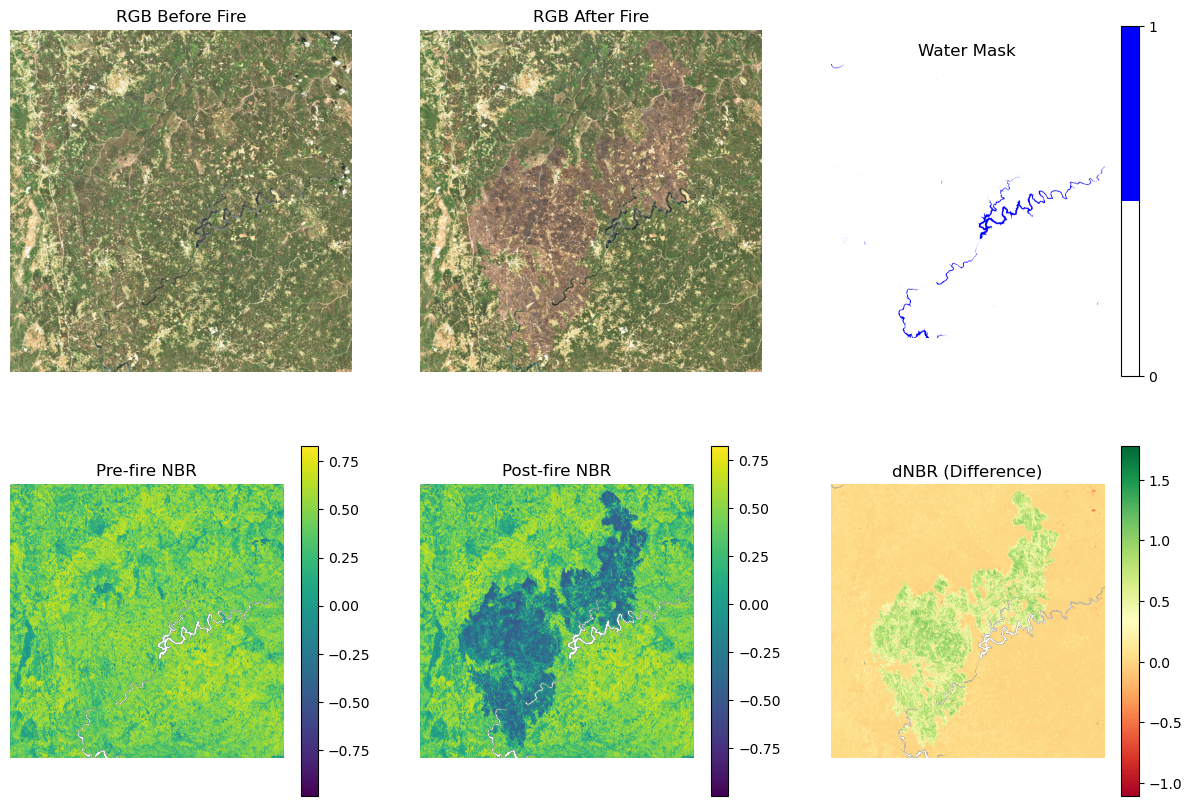

In [78]:
# ################### Plotting ################
# Erstelle die Figur und GridSpec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)

# Erste Zeile: Zwei zentrierte Plots
ax1 = fig.add_subplot(gs[0, 0])  # Überspannt die erste und zweite Spalte
ax2 = fig.add_subplot(gs[0, 1])  # Überspannt die zweite und dritte Spalte
ax6 = fig.add_subplot(gs[0, 2])  # Add to the first column of the second row

# Zweite Zeile: Drei Plots
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

# Plot RGB image
ax1.imshow(rgb_before)
ax1.set_title("RGB Before Fire")
ax1.axis("off")

# Plot RGB image
ax2.imshow(rgb_after)
ax2.set_title("RGB After Fire")
ax2.axis("off")

# Plot pre-fire NBR
img3 = ax3.imshow(prefire_nbr, cmap="viridis")
ax3.set_title("Pre-fire NBR")
ax3.axis("off")
fig.colorbar(img3, ax=ax3, orientation="vertical")


# Plot post-fire NBR
img4 = ax4.imshow(postfire_nbr, cmap="viridis")
ax4.set_title("Post-fire NBR")
ax4.axis("off")
fig.colorbar(img4, ax=ax4, orientation="vertical")

# Plot dNBR
img5 = ax5.imshow(dNBR, cmap="RdYlGn")
ax5.set_title("dNBR (Difference)")
ax5.axis("off")
fig.colorbar(img5, ax=ax5, orientation="vertical")

img6 = ax6.imshow(water_mask_before, cmap= ListedColormap(["white", "blue"]))
ax6.set_title("Water Mask")
ax6.axis("off")
fig.colorbar(img6, ax=ax6, orientation="vertical", ticks=[0, 1])

plt.show()

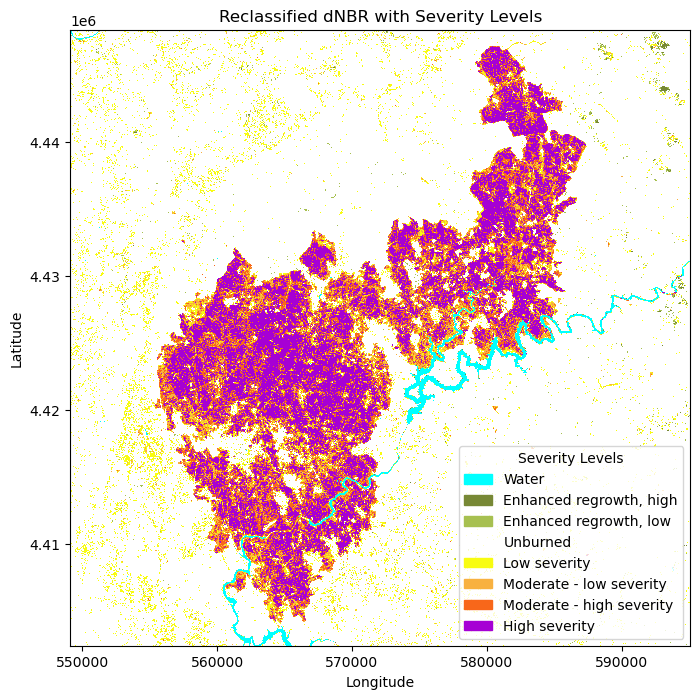

In [79]:
# Reclassify dNBR values
dNBR_classes, dNBR_legend = wt.reclassify_dnbr(dNBR)

# Color mapping for classes
colors = [
    "#00ffff",  # water (blue)
    "#778835",  # Dark Green (Enhanced regrowth, high)
    "#a7c050",  # Green (Enhanced regrowth, low)
    "#00000000",  # Bright Green (Unburned)
    "#f8fc11",  # Yellow (Low severity)
    "#f8b140",  # Orange (Moderate - low severity)
    "#f8671a",  # Red (Moderate - high severity)
    "#a600d4",  # Violet (High severity)
]
cmap = ListedColormap(colors)

# Legend for plotting
legend_patches = [Patch(color=colors[i], label=dNBR_legend[i]) for i in range(len(colors))]

# Plotting
plt.figure(figsize=(8, 8))
im = dNBR_classes.plot.imshow(cmap=cmap, add_colorbar=False)
plt.title("Reclassified dNBR with Severity Levels")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add legend
plt.legend(handles=legend_patches, loc="lower right", title="Severity Levels")
plt.show()

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Processing year: 2015
Processing scene for day: 2015-07-25T11:20:46.027000000
[0.6344358139697499]
[0.4195677050506565]
[numpy.datetime64('2015-07-25T11:20:46.027000000')]
Processing year: 2016
Processing scene for day: 2016-07-02T11:33:22.026000000
Processing scene for day: 2016-07-09T11:21:22.026000000
Processing scene for day: 2016-07-19T11:21:22.026000000
Processing scene for day: 2016-07-29T11:21:22.027000000
[nan, 0.6672049171124503, 0.6433075565344304, 0.654745409464267]
[nan, 0.43438105445007874, 0.44347686185052154, 0.446658144217347]
[numpy.datetime64('2016-07-02T11:33:22.026000000'), numpy.datetime64('2016-07-09T11:21:22.026000000'), numpy.datetime64('2016-07-19T11:21:22.026000000'), numpy.datetime64('2016-07-29T11:21:22.027000000')]
-0.026785769838877708
Processing year: 2017
Processing scene for day: 2017-07-04T11:21:11.026000000
Processing scene for day: 2017-07-14T11:21:11.026000000
Processing scene for day: 20

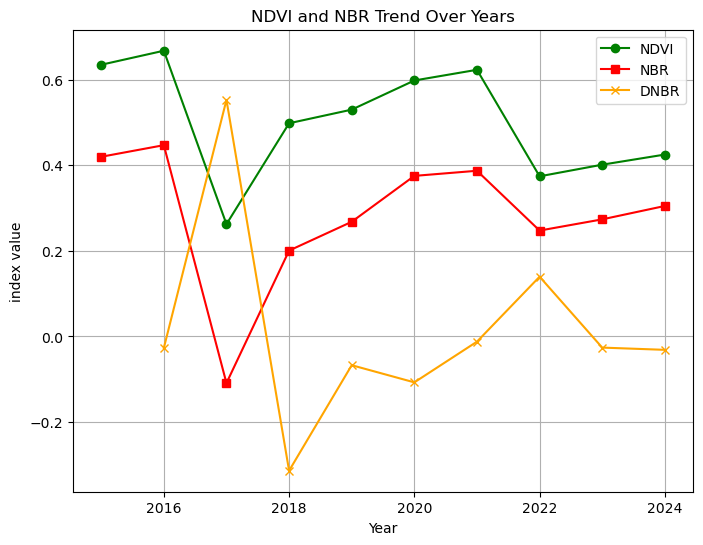

In [80]:
# Calculate Indices for regrowth analysis NDVI and NBR

years = list(range(2015,2025,1))
print(years)

NDVI = []
NBR = []
DNBR = []

# create burn mask 
burn_mask, legend_burn_mask = wt.burn_mask(dNBR, 0.1) # th = threshold for reclassification


# create water mask
water_mask_before, legend = wt.water_mask(ndwi_before, 0.1) # th = threshold for reclassification

for year in years:

    print(f"Processing year: {year}")

    da_year = cubo.create(
        lat=39.9756, # Central latitude of the cube
        lon=-8.1556, # Central longitude of the cube
        collection="sentinel-2-l2a", # Name of the STAC collection
        bands=["B04","B08","B12", "SCL"], # Bands to retrieve
        start_date=str(year) + "-07-01", # Start date of the cube
        end_date=str(year) + "-07-31", # End date of the cube
        edge_size=46000, # Edge size of the cube 46000
        units = "m",
        resolution=10, # Pixel size of the cube (m)
        query={"eo:cloud_cover": {"lt": 10}} # kwarg to pass
    )
    
    mean_ndvi = []
    mean_nbr = []
    days = []
    
    if year >= 2016:
        nbr_year_before = nbr_max_xarray.copy(deep=True)

    for day in da_year.time.values:

        print(f"Processing scene for day: {day}")
        scene = da_year.sel(time=day)
        
        # Apply the burn mask to scene
        scene = wt.apply_burn_mask(scene, burn_mask)
        

        # Apply the water mask to scene
        scene = wt.apply_water_mask(scene, water_mask_before)
        
        # create cloud mask
        scl_layer = scene.sel(band= "SCL")
        cloud_mask, legend_cloud_mask = wt.cloud_mask(scl_layer)

        # apply cloud mask
        scene = scene.where(cloud_mask == 1)

        # calculate ndvi and nbr for scene
        ndvi_scene = wt.ndvi(scene)
        nbr_scene = wt.nbr(scene)


        # append scene ndvi to mean ndvi values for year
        mean_ndvi.append(float(ndvi_scene.mean().values))
        mean_nbr.append(float(nbr_scene.mean().values))
        days.append(day)
        
    print(mean_ndvi)
    print(mean_nbr)
    print(days)

    # append max ndvi from year to generell ndvi list
    NDVI.append(np.nanmax(mean_ndvi))
    NBR.append(np.nanmax(mean_nbr))

    # get max nbr xarray
    scene = da_year.sel(time=days[mean_nbr.index(np.nanmax(mean_nbr))])

    # Apply the burn mask to scene
    scene = wt.apply_burn_mask(scene, burn_mask)

    # Apply the water mask to scene
    scene = wt.apply_water_mask(scene, water_mask_before)
        
    # create cloud mask
    scl_layer = scene.sel(band= "SCL")
    cloud_mask, legend_cloud_mask = wt.cloud_mask(scl_layer)

    # apply cloud mask
    scene = scene.where(cloud_mask == 1)

    nbr_max_xarray = wt.nbr(scene)

    if year == 2015:
        DNBR.append(np.nan)

    if year >= 2016:
        dnbr_plot = nbr_year_before - nbr_max_xarray
        dnbr_yearly = float(dnbr_plot.mean().values)
        print(dnbr_yearly)
        DNBR.append(dnbr_yearly)
    
    

print(NDVI)
print(NBR)
print(DNBR)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(years, NDVI, marker='o', linestyle='-', color='green', label='NDVI')
plt.plot(years, NBR, marker='s', linestyle='-', color='red', label='NBR')
plt.plot(years, DNBR, marker='x', linestyle='-', color='orange', label='DNBR')

# Labels and title
plt.xlabel('Year')
plt.ylabel('index value')
plt.title('NDVI and NBR Trend Over Years')

# Grid and legend
plt.grid(True)
plt.legend()

# Show plot
plt.show()